In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Define the incoming nodes
def dic_node_income(network):
    dic_nodes_incoming = {}
    for node in set(network['node2']):
        dic_nodes_incoming[node] = {}
        cur_df = network[network['node2'] == node]
        for node_income in cur_df['node1']:
            if cur_df[cur_df['node1'] == node_income]['Operation'].values[0] == 'activate':
                dic_nodes_incoming[node][node_income] = "activate"
            else:
                dic_nodes_incoming[node][node_income] = "inactivate"

    return dic_nodes_incoming


def initial_model(all_nodes, initial_values):
    # Initialize the model
    model = {}
    for i in range(0, len(all_nodes)):
        model[list(all_nodes)[i]] = initial_values[i]

    return model


def node_update_rules_withoutNoise(init_cur_upstream_values, init_cur_operation):
    '''
    Example input:
    init_cur_upstream_values = [True,False,False,True]
    init_cur_operation = ["activate","activate","activate",'inactivate']    
    '''
    # get the index of the operation where the operation is activate
    active_index = [i for i, x in enumerate(init_cur_operation) if x == "activate"]
    inactive_index = [i for i, x in enumerate(init_cur_operation) if x == "inactivate"]

    active_index
    cur1 = True
    for index in active_index:
        cur1 = cur1 or init_cur_upstream_values[index]

    cur2 = False
    for index in inactive_index:
        cur2 = cur2 or init_cur_upstream_values[index]

    result = cur1 and (not cur2)
    return result

def node_update_rules(init_cur_upstream_values, init_cur_operation):
    '''
    Example input:
    init_cur_upstream_values = [True,False,False,True]
    init_cur_operation = ["activate","activate","activate",'inactivate']    
    '''
    # get the index of the operation where the operation is activate
    active_index = [i for i, x in enumerate(init_cur_operation) if x == "activate"]
    inactive_index = [i for i, x in enumerate(init_cur_operation) if x == "inactivate"]

   
    if len(active_index) > 0:
        cur1 = False
        for index in active_index:
            cur1 = cur1 or init_cur_upstream_values[index]
    else:
        cur1 = False

    if len(inactive_index) > 0:
        cur2 = False
        for index in inactive_index:
            cur2 = cur2 or init_cur_upstream_values[index]
    else:
        cur2 = False

    result = cur1 and (not cur2)
    return result

def xor(a, b):
    return (a and not b) or (not a and b)


def update_model_with_flip_onestep(model_t0, dic_nodes_incoming, noise):
    model_t1 = model_t0.copy()
    all_nodes = list(model_t0.keys())
    n = 0

    for cur_node in all_nodes:
        n = n + 1
        if noise[n-1] == True:
            cur_node_value =  xor(model_t0[cur_node], noise[n-1])

        else:
            if cur_node in list(dic_nodes_incoming.keys()):
                updstream_nodes =list(dic_nodes_incoming[cur_node].keys())
                init_cur_upstream_values = []
                init_cur_operation = []

                for upstream_node in updstream_nodes:
                    init_cur_upstream_values.append(model_t0[upstream_node])
                    init_cur_operation.append(dic_nodes_incoming[cur_node][upstream_node])

                cur_node_value = node_update_rules(init_cur_upstream_values,init_cur_operation )

            else:
                cur_node_value = model_t0[cur_node]

        model_t1[cur_node] = cur_node_value
        
    return(model_t1)

def update_model_without_flip_onestep(model_t0,dic_nodes_incoming):
    model_t1 = model_t0.copy()

    for cur_node in list(model_t0.keys()):

        if cur_node in list(dic_nodes_incoming.keys()):
            updstream_nodes =list(dic_nodes_incoming[cur_node].keys())
            init_cur_upstream_values = []
            init_cur_operation = []

            for upstream_node in updstream_nodes:
                init_cur_upstream_values.append(model_t0[upstream_node])
                init_cur_operation.append(dic_nodes_incoming[cur_node][upstream_node])
            
            cur_node_value = node_update_rules_withoutNoise(init_cur_upstream_values,init_cur_operation)
            model_t1[cur_node] = cur_node_value

        else:
            model_t1[cur_node] = model_t0[cur_node]
    
    return(model_t1)
    
def update_models_multisteps(model_initial,dic_nodes_incoming, runs = 20, fliprop = 0.01):
    model = model_initial.copy()
    models = {}
    for node in list(model_initial.keys()):
            models[node] = [model_initial[node]]

    for run in range(0,runs): 
        all_nodes = list(model_initial.keys())
        noise = np.random.uniform(0,1,len(all_nodes))
        noise[noise < fliprop] = True  # 0.01 chance to flip the value
        noise[noise != True] = False  
    
        if True in noise:
            model_t1 = update_model_with_flip_onestep(model,dic_nodes_incoming,noise)   
        else:
            model_t1 = update_model_without_flip_onestep(model,dic_nodes_incoming)
        
        for node in list(model_t1.keys()):
            models[node].append(model_t1[node])
        
        model = model_t1.copy()

    return(models)


In [66]:

network = pd.DataFrame({"1":["X","Y","activate"],
                        "2":["X","X","activate"],
                        "3":["X","Z","activate"],
                        "4":["Y","X","activate"],
                        "5":["Y","Y","activate"],
                        "6":["Y","Z","inhibit"],
                        "7":["Z","Z","activate"]
})

network = network.transpose()
network.columns = ["node1","node2","Operation"]

# Analyze the structure of the network
# Load initial network data
#network = pd.read_csv('/Users/guangrong/Documents/GitHub_project/AML digital twin/script/FLT3_NPM1_DNMT3A_model1.csv')
#network = pd.read_csv('/Users/guangrong/Documents/GitHub_project/AML digital twin/script/FLT3_NPM1_DNMT3A_add.csv')

#print("starting nodes:")
#print(set(network['node1']) - set(network['node2']))

#print("ending nodes:")
#print(set(network['node2']) - set(network['node1']))

#print("all nodes:")
#print(len(set(network['node1']) | set(network['node2'])))



In [67]:
all_nodes = list(set(network['node1']) | set(network['node2']))
print(all_nodes)

# random initial values
initial_values = [random.choice([True,False]) for i in range(0,len(all_nodes))]
curr_initial_values = initial_values.copy()
#initial_values = curr_initial_values
#initial_values = [True] * len(all_nodes)
dic_nodes_incoming = dic_node_income(network)
print(curr_initial_values)
model_initial = initial_model(all_nodes=all_nodes, initial_values=initial_values)

simulations = update_models_multisteps(model_initial,dic_nodes_incoming, runs = 10000, fliprop=0.05)
#simulations = model_update_withNoise(model_initial,dic_nodes_incoming, runs = 100)

# Convert the simulation results to dataframe so True will became 1 and False will became 0
for node in simulations.keys():
    simulations[node] = [int(x) for x in simulations[node]]
simulations = pd.DataFrame(simulations)  

# heatmap of the simulation results


['Z', 'X', 'Y']
[False, True, True]


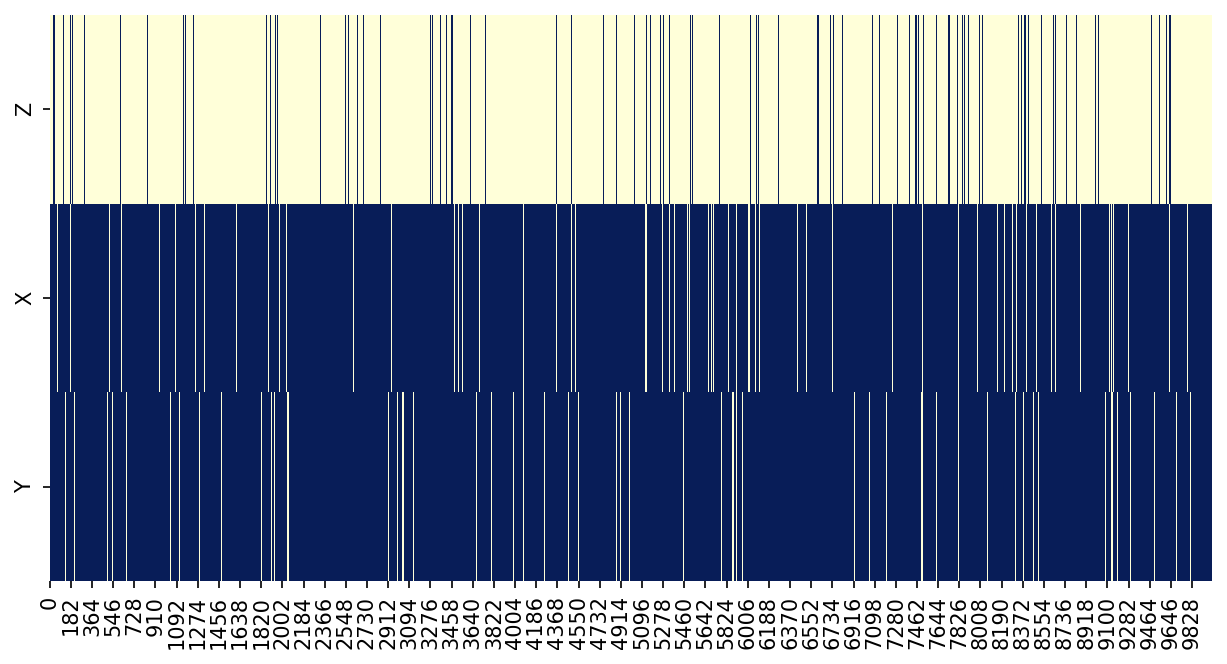

In [68]:
plt.figure(figsize=(10,5), dpi = 150)
# heapmap without clustering
#
sns.heatmap(simulations.transpose(),cmap="YlGnBu", cbar = False)
plt.show()


In [69]:
X1 = simulations.loc[simulations['X'] == 1,] 
X1Y1 = X1.loc[X1['Y'] == 1,]
X1Y1Z1 = X1Y1.loc[X1Y1['Z'] == 1,]
X1Y1Z0 = X1Y1.loc[X1Y1['Z'] == 0,]
X1Y0 = X1.loc[X1['Y'] == 0,]
X1Y0Z1 = X1Y0.loc[X1Y0['Z'] == 1,]
X1Y0Z0 = X1Y0.loc[X1Y0['Z'] == 0,]
X0 = simulations.loc[simulations['X'] == 0,]
X0Y1 = X0.loc[X0['Y'] == 1,]
X0Y1Z1 = X0Y1.loc[X0Y1['Z'] == 1,]
X0Y1Z0 = X0Y1.loc[X0Y1['Z'] == 0,]
X0Y0 = X0.loc[X0['Y'] == 0,]
X0Y0Z1 = X0Y0.loc[X0Y0['Z'] == 1,]
X0Y0Z0 = X0Y0.loc[X0Y0['Z'] == 0,]



In [70]:
result_df = pd.DataFrame({"state":["X0Y0Z0","X0Y0Z1","X0Y1Z0","X0Y1Z1","X1Y0Z0","X1Y0Z1","X1Y1Z0","X1Y1Z1"],
                         "ratio":[X0Y0Z0.shape[0]/simulations.shape[0], 
 X0Y0Z1.shape[0]/simulations.shape[0], 
 X0Y1Z0.shape[0]/simulations.shape[0],
 X0Y1Z1.shape[0]/simulations.shape[0], 
 X1Y0Z0.shape[0]/simulations.shape[0],
 X1Y0Z1.shape[0]/simulations.shape[0], 
 X1Y1Z0.shape[0]/simulations.shape[0], 
 X1Y1Z1.shape[0]/simulations.shape[0]]})

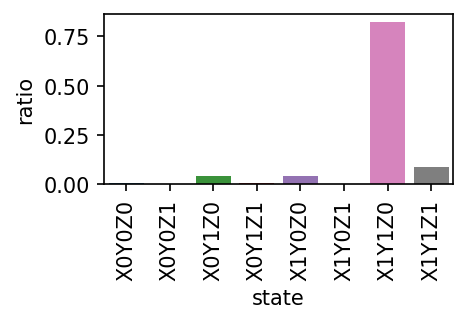

In [71]:

#barplot of result_df

plt.figure(figsize=(3,1.5), dpi = 150)
sns.barplot(x = "state", y = "ratio", data = result_df)
plt.xticks(rotation = 90)
plt.show()

